# 17 - Exploration of Historical NBA Players (Part VII, Advanced Metrics)
In post \#13, I glossed over advanced metrics and tried to plot them on a PCA plot. Didn't really work as I didn't really think it through and I just threw everything up. At one point, I was plotting things like AST% to something like VORP. While we can throw anything on a PCA in theory, it's probably best to think a bit about what exactly we're trying to accomplish as well because, like we saw last time, certain features constrain the make up of certain principal components, and it really is quite irresponsible to be throwing these constraints on without thinking about the objective a little bit.

For example, if we threw on something like win shares to the previous basic metric plots, well it doesn't quite make sense because the metrics we were using, PTS, AST, ORB, DRB... etc are attributes that certain types of players would have. We're in a sense describe what "kind" or "style" of player someone is by plotting them on the chart. Win Shares, on the other hand, is telling us how many "Wins" the player accounts for within his team. A player can contribute to wins with any number of these stats, right? Allen Iverson and Shaq both had huge impacts on their teams, and they were extremely different players. AI and Shaq, as we've seen, both fall in completely opposite sides of the plot, so adding Win Shares would just constrain the plot even more, possibly to the point where the plot wouldn't make sense or would be extremely difficult or even incorrect to interpret in 2 dimensions.

![](http://i.imgur.com/iPAB5n1.gif)

I don't know _**WHAT**_ that is... but that's pretty much like throwing too many dimensions at PCA, especially dimensions that don't make sense to plot with each other.

## Advanced Metrics

In post \#13, althought I glossed over the advanced metrics portion, I did have one plot that was interesting when I took a look at the all-encapsulating metrics:

In [2]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Yay, I cleaned that load library code a little bit. And by clean up, I mean put into one codebox instead of 3.

![](http://blog.storage.com/wp-content/uploads/2015/05/acceptance-self-five-how-i-met-your-mother.gif)

The way I was initiating the R libraries separately was because I thought that the single pecent operator %R only initiated a temporary R kernel for that one line of ad-hoc code. Why? Did the documentation say that? Did any tutorials for rpy2 mention that? Nope. I have no idea why I thought that, but it has become extremely clear and useful knowing that I can %R within even a python function or loop. Christ if I had only known since the beginning...

In [22]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [8]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'advancedStats_PER',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]].dropna()

playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesLabel = playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures['perGameStats_Pos'].tolist()
playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeatures.drop('perGameStats_Pos', 1)

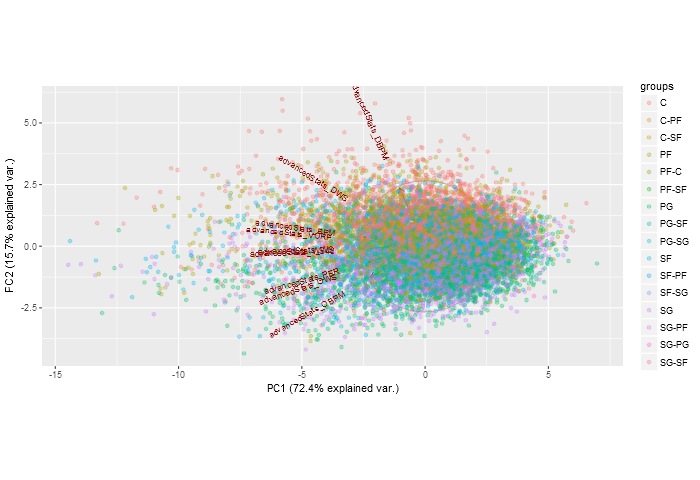

In [10]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesLabel -i playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData -w 700 -u px

# Fit PCA model
advancedAllEncapPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesData, center = T, scale = T)
ggbiplot(advancedAllEncapPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.3, group = playerAggDfToAnalyzeMin10Min20GamesPCAAllEncapFeaturesLabel)

While not as clear a division as we saw in the plot with basic metrics, this advanced metrics biplot shows all the all-encapsulating metrics (i.e. not measuring single stats like AST% or TS%) and whether they favor guards or big men. I'd like to just plot one metric onto the biplot and see how the basic metrics contribute to it. By this plot, it looks like the following are _**relatively**_ neutral
- BPM
- VORP
- WS

PER seems to actually favor guards... didn't know that but ok sure. I will not use PER.

You know, even before I get into any more plots, I should probably review these statistics and just make sure I understand what they mean and how they're calculated again...

### PER - Player Efficiency Rating
I won't get into any formulas here because 1) I'm not 100% familiar with them or can even understand them myself, and 2) that's a whole separate discussion in itself, but...

PER, as per basketball-reference, is a stat created by John Hollinger that
> _**sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance"**_

Theoretically, PER should be extremely correlated with my plot because it's literally just measuring the totals of these numbers, kind of like what I did with the plot label text size (AST + TRB + STL + BLK). His is basically mine on crack. No, that doesn't really do it justice. If his is an iPhone, mine is the string between two cans of five year olds who play with their soup can telephones for about 2 minutes and throw it away to the side of the playground in which hundreds of other kids trample every day and it is then just a forgotten hazard that some kid may trip and hurt himself on later. Dramatic? I think not.

<img src="http://i.imgur.com/r9mlb57.gif" width="300">

### BPM - Box Plus Minus
As per basketball-reference:
> _**Box score estimate of the points per 100 possessions that a player contributed above a league-average player, translated to an average team.**_

Oh, well why didn't you say so! Wait... what??

Okay, well I know what Plus Minus is... It's the net points that your team gains / loses for the duration of the time you're on the floor. Let's say you play a total of 5 minutes, but you're one of the worst bench players the team has ever seen. Multiple stars on your team are injured and you have to play 5 crucial minutes at the end of the first. Your team has a 10 point lead when you enter, and you're tied at the end of the quarter. Your +/- is then -10. Ouch!

Now... how the hell does BOX + / - work...

UPDATE: The last sentence was typed at 3pm. It is now 12:10am. Ok sure I had dinner and went to tennis in between, but there's probably a good 5 hours in there I was just reading articles. Boy did it not make sense in the beginning, and boy does it make sense now.

Man... how do I start without basically just repeating everything word for word I just read and making this post into a short story. We have to start with plus minus. The whole point of plus minus is to see who is correlated to _**WINNING**_. Forget rebounds, assists, steals... forget who switches, forget who takes the offensive charges... who makes an _**impact to the bottom line of points**_. Yes, we are in essence accounting for all of those factors I just said to forget about, but we aren't measuring one or the other directly. If a player is good, they should be pushing the team to get points and preventing the opponent from getting points, right?

So that's basically the skinny on plus minus, easy enough. Now tracking plus minus by itself leads to certain issues. As Daniel Myers explains in his article [here](http://godismyjudgeok.com/DStats/2011/nba-stats/a-review-of-adjusted-plusminus-and-stabilization/), if I'm on the floor (me, Chi Wang) with Lebron, Wade, and Bosh, I'm probably gonna have a decent plus minus aside from the fact that I'm absolute trash.

![](http://bestanimations.com/Sports/Basketball/great-basketball-court-plays-animated-gif-1.gif)

My plus minus will be extremely misleading because I'm basically riding the coattails of 3 legends. So how do we adjust for who we're playing with? The answer, actually, is a simple linear regression. WHO'DA THUNK IT.

So how [Dan Rosenbaum](http://www.82games.com/comm30.htm) explains the _**Adjusted Plus Minus**_ is that basically he performed a regression on Plus Minus using every single lineup ever played in a single season. Basically he was able to get stats for every game, and a breakdown of the plus minus margin of the whole game with every single lineup. I didn't look at the raw data, but I'd imagine it to be something like this...

In [16]:
pd.DataFrame({
    'point_margin': [2, 8, 0, 2, -6, -10],
    'minutes': [4, 5, 3, 5, 8, 7],
    'home_player_1': ['Mario Chalmers', 'Mario Chalmers', 'Mario Chalmers', 'Norris Cole', 'Norris Cole', 'Mario Chalmers'],
    'home_player_2': ['Dwyane Wade', 'Dwyane Wade', 'Mike Miller', 'Mike Miller', 'Mike Miller', 'Mike Miller'],
    'home_player_3': ['Lebron James', 'Lebron James', 'Lebron James', 'Lebron James', 'Lebron James', 'James Jones'],
    'home_player_4': ['Udonis Haslem', 'Udonis Haslem', 'Joel Anthony', 'Joel Anthony', 'Joel Anthony', 'Joel Anthony'],
    'home_player_5': ['Chris Bosh', 'Chris Bosh', 'Chris Bosh', 'Chris Bosh', 'Chris Bosh', 'Chris Bosh'],
    'away_player_1': ['Patty Mills', 'Patty Mills', 'Patty Mills', 'Tony Parker', 'Tony Parker', 'Tony Parker'],
    'away_player_2': ['Manu Ginobili', 'Manu Ginobili', 'Manu Ginobili', 'Manu Ginobili', 'Manu Ginobili', 'Manu Ginobili'],
    'away_player_3': ['Stephen Jackson', 'Stephen Jackson', 'Stephen Jackson', 'Stephen Jackson', 'Stephen Jackson', 'Stephen Jackson'],
    'away_player_4': ['Matt Bonner', 'Matt Bonner', 'Matt Bonner', 'Matt Bonner', 'Tim Duncan', 'Tim Duncan'],
    'away_player_5': ['Boris Diaw', 'Tiago Splitter', 'Tiago Splitter', 'Tiago Splitter', 'Tiago Splitter', 'Tiago Splitter']
})[[
    'point_margin',
    'minutes',
    'home_player_1',
    'home_player_2',
    'home_player_3',
    'home_player_4',
    'home_player_5',
    'away_player_1',
    'away_player_2',
    'away_player_3',
    'away_player_4',
    'away_player_5'
]]

point_margin  minutes   home_player_1 home_player_2 home_player_3  \
0             2        4  Mario Chalmers   Dwyane Wade  Lebron James   
1             8        5  Mario Chalmers   Dwyane Wade  Lebron James   
2             0        3  Mario Chalmers   Mike Miller  Lebron James   
3             2        5     Norris Cole   Mike Miller  Lebron James   
4            -6        8     Norris Cole   Mike Miller  Lebron James   
5           -10        7  Mario Chalmers   Mike Miller   James Jones   

   home_player_4 home_player_5 away_player_1  away_player_2    away_player_3  \
0  Udonis Haslem    Chris Bosh   Patty Mills  Manu Ginobili  Stephen Jackson   
1  Udonis Haslem    Chris Bosh   Patty Mills  Manu Ginobili  Stephen Jackson   
2   Joel Anthony    Chris Bosh   Patty Mills  Manu Ginobili  Stephen Jackson   
3   Joel Anthony    Chris Bosh   Tony Parker  Manu Ginobili  Stephen Jackson   
4   Joel Anthony    Chris Bosh   Tony Parker  Manu Ginobili  Stephen Jackson   
5   Joel Anthony    Chris Bosh   Tony Parker  Manu Ginobili  Stephen Jackson   

  away_player_4   away_player_5  
0   Matt Bonner      Boris Diaw  
1   Matt Bonner  Tiago Splitter  
2   Matt Bonner  Tiago Splitter  
3   Matt Bonner  Tiago Splitter  
4    Tim Duncan  Tiago Splitter  
5    Tim Duncan  Tiago Splitter

Here, I've generated some data (please don't quote me on ANY of these lineups or ANY of these numbers...) to demonstrate what Dan Rosenbaum had to work with. I'm not sure if he got the data exactly like this, or he manipulated it to be something like this, but the way we have it now, we can essentially see a linear regression being built!

Each of your players become a categorical feature... we'll have 400 some odd features for every single player in the NBA, and then we'd basically perform a regression to predict _**point margin**_. And this actually kinda makes sense! Each sample of the population is a different line up, and should tell a more all-inclusive story about the point margin accounting for everyone on the floor! The regression model would pick up if, time after time after time, Tim Duncan was a correlating force with all the positive changes in point margin, and that his absence also causes the other team offensive troubles.

At the end of the day, we get something like

$$MARGIN=\beta_0+\beta_1 X_1+\beta_2 X_2 +...+\beta_K X_K$$

where _**K**_ is the number of players in the league.

You have certain intricacies with sample size because certain players may only play with other players, or certain players may never play with other players (they may exclusively get subbed out for each other), so Dan Rosenbaum takes the regression ONE LEVEL DEEPER.

<img src = "http://i2.kym-cdn.com/photos/images/facebook/000/531/557/a88.jpg" style = "width: 400px;"/>

We now have these betas

$$\beta_1, \beta_2,...,\beta_K$$

which basically represent the impact that a player has on the margin. Perhaps

$$\beta_1=Kevin\ Garnett$$
$$\beta_2=Tim\ Duncan$$
$$\beta_3=Lebron\ James$$

and so on and on forth. Dan takes it a step further by then building ANOTHER regression model that tries to predict these betas with actual basketball metrics like REB / AST / STL... etc. You'd then get, out of a sample of every player in the association, an idea of "assists are this important to a team's margin increase, rebounds are that important... etc etc". You could then take each players statlines and essentially "predict" their individual plus minus. You then create a model out of it on historical data and use it to "predict" their individual plus minus and this... my friend... is the _**Box Plus Minus**_.

Kapiche? Phew...

In our data, basketball-reference uses advanced metrics in their model:

Raw BPM = a*ReMPG + b*ORB% + c*DRB% + d*STL% + e*BLK% + f*AST% - g*USG%*TO% + h*USG%*(1-TO%)*[2*(TS% - TmTS%) + i*AST% + j*(3PAr - Lg3PAr) - k] + l*sqrt(AST%*TRB%)

It's a gongshow, I know, but it makes sense if you get that this is a regression model and that essentially all of these are just features, with a few modified features and interaction terms (e.g. sqrt(AST%\*TRB%) presumably accounting for players who "do it all", or big men who can rebound but are also skilled enough to pass).

This "Raw BPM" as they call it is then adjusted for pace and team efficiency and strength of schedule to get a final per 100 stat where +5 is in the elite range, 0 is average, and -5 is within the poorer range.

One final thing to note here is that the regressions performed use _**ridge regression**_. Normal regression tries to minimize the _**least squared error**_

$$(y_i-\sum{x_i\beta_i})^2$$

which just takes the predictions, finds the difference between them and the real values, and squares the error (the model chosen will have the minimum error, or will be trying to _**optimize**_ this error.

Ridge regression adds a constraint to this error in the form of

$$(y_i-\sum{x_i\beta_i})^2+\lambda\sum{\beta_i^2}$$

saying that the sum of the coefficients themselves actually add to the error. We are now left to find a balance between the squared error and the coefficients. In a way that I won't get into too much detail about, this basically prevents _**overfitting**_. The coefficients cannot be so crazy as to satisfy a certain population, but must consider the entire population every time a coefficient is fit because that penalty term will play a role as coefficients get too crazy. This forces the regression to efficiently find, essentially the principal components and find the variables that explain those variances the most while coefficients of smaller principal components get squeezed closer and closer to zero.

All this for Box Plus Minus...??? Christ... WELP. THERE IT IS.

### VORP - Value Over Replacement Player
VORP... hang onto your seats boys we're goin in again... just kidding.

VORP is based on BPM and can be explained as long as you know what BPM is. I'm sure there's a large chance I still don't know what BPM is, but let's go off our assumed knowledge haha.

From bball-ref:
>_**Value over Replacement Player (VORP) converts the BPM rate into an estimate of each player's overall contribution to the team, measured vs. what a theoretical "replacement player" would provide, where the "replacement player" is defined as a player on minimum salary or not a normal member of a team's rotation.**_

Alrighty then. That is, again, NOT confusing at all! Now what the hell is a _**replacement player**_... Well the originator of the replacement player concept, [Tom Tango](http://tangotiger.com/index.php/site/comments/what-is-a-replacement-level-nba-player) had originally thought of this concept in the context of baseball. It's essentially a low performing player, almost at like a zero ranking (low salary, poor performance, little minutes), that we could replace the actual player we're trying to measure and take away all their value. The replacement player is seen as almost just a body who brings very little value to a team.

If we take a look at BPM again, BPM is a plus minus at the end of the day adjusted for pace right? BPM is saying, for every 100 possessions, Lebron (BPM has been in the 12-13 range) is essentially bringing 12-13 points more value to you than someone with a BPM of 0.

A replacement player, again, is a someone with relatively _**low**_ performance, so the replacement player is actually worse than an average player. The VORP scale has been defined such that a replacement player lies at a -2.0 rating. I think, within baesball, the replacement player basically doesn't do much. They don't see much playing time, and is a good baseline to measure someone without a rating essentially. In basketball, as bball-ref says, replacement players actually do see playing time whether it's garbage time or teams are tanking. Tom Tango took a replacement player in the NBA to be essentially someone who isn't part of a team's usual 8-10 man rotation, and I think he did this by taking top 300 or whatever players in the league in terms of minutes played (top 10 for each team).

So VORP is basically just the value of a player _**over a replacement player**_.

$$VORP=BPM-(-2.0)$$

Basketball-reference also adjusts VORP for playing time so, if a player played tons of minutes and games for his team he would have had a greater value and therefore a greater VORP. So, then, our final VORP equation becomes

$$VORP=(BPM-(2.0))\times (\%\ of\ Minutes\ Played)\times (\%\ of\ Games\ Played)$$

### WS - Win Shares
Ah, last one here that we'll be looking at. Win Shares. Bball-ref:

>_**Win Shares is a player statistic which attempts to divvy up credit for team success to the individuals on the team. Important things to note are that it is calculated using player, team and league-wide statistics and the sum of player win shares on a given team will be roughly equal to that team’s win total for the season.**_

This one is a bit insane as well. I don't think I'll get too deep into it but just enough for it to make sense for myself. Here I'm going off this [reddit thread](https://www.reddit.com/r/nba/comments/2bv4cp/stats_101_win_shares/) that some nice young gentleman (sorry, I'm assuming here haha) wrote up. The reddit thread explains the fundamental idea of a win share, but basketball-reference makes many changes that the same reddit guy also expanded on [here](https://www.reddit.com/r/l_davies93/comments/2bgzw2/modifications_to_win_shares_by_basketball/).

There are a few different parts to win shares:

**Team Offensive / Defensive Win Shares**

We start off with a little... Pythagorean's theorem??! I guess so! Actually, even before that, we start off with baseball again and the idea that the amount of runs you score and the amount of runs you limit your opponent to should effectively be able to predict how "good" you are or how many "wins" you'd get. For example, if you consistently averaged like 10 runs and held your opponent to 1, you'd probably be winning every game. If you averaged 1 run for, and 10 runs against on the season. You probably didn't win many games, if any.

Bill James came up with this relationship (and Daryl Morey (wait what...? Daryl Morey? (I just googled Daryl Morey and it seems like he came up with TS%... wtf? And he's a comp sci grad? Who'da thunk it)) applied it to baseball).

$$MLB\ Team\ Wins=\frac{(Runs\ Scored)^2}{(Runs\ Scored)^2+(Runs\ Allowed)^2}$$

Somehow this has a really really high accuracy in baseball haha. Daryl Morey then repurposed it for basketball:

$$NBA\ Team\ Wins=\frac{(Points\ Scored)^{13.91}}{(Points\ Scored)^{13.91}+(Points\ Allowed)^{13.91}}$$

And the story begins. This has been called by Morey as "Pythagorean Expectation". It's not quite Pythagorean's theorem, but you can see the similarity. Off the presumption that this relationship exists, we can basically generalize it to a statement like
- On the offensive end, the more you help your team score, the more you help your team win
- On the defensive end, the more you limit your opponent from scoring, the more you help your team win

And basically win shares was born. We start off by trying to measure how much better a team is than a team of replacement players (this basically is trying to emulate absolute 0 on a team level - similar to how a replacement player was your player who wasn't even the rotation, your replacement team is a team full of replacement players).

This baseline is taken because let's say you're a great team and are scoring at like 115 ORtg and, on average, the league was scoring 105. You'd be scoring 10 more points than your average team which would contribute to your win shares. Perfect.

If you were a sub-par team scoring let's say 95 ORtg. Your margin would be negative @ -10. This would actually cause your wins to be negative and this causes a few problems.
- First of all, it simply doesn't make sense
- Second of all, your absolute value is negative, so if your best player contributes the most, he'd actually get the lowest win share on the team (you have like -10 win shares and your best player accounts for 40% of that, he'd have -4 while the rest of the your team has an average of like -1, doesn't make sense that he has the _**lowest**_ value!

To avoid this problem, we set an _**"absolute zero"**_ of the worst team that can be possibly assembled, a team full of replacement players. This way, if you're a horrible team, you'd still be close to the replacement team and you'd end up with around 0 win calculated rather than negative.

Your offensive team margin would then be the difference between your points scored and what the replacement team would've scored. Your defensive margin would also be the difference between the points you allowed and what the replacement team would've allowed. Note that these _**CAN**_ be negative, but for the most part because of the adjustment it generally is not.

Note that, because of our pythagorean's theorem formula, we're also essentially calculating "how many wins did we get". Then, by divvying up these offensive and defensive margins to players, we're also divvying up the "wins".

**Player Offensive / Defensive Win Shares**

In traditional win shares, once we have the point margins, we find what each player scored / allowed in comparison with the replacement player and divvy up the shares that way. Basketball-reference seems to do it another way, and they don't even calculate team win shares at all.

On the offensive side, they use the _**"points produced"**_ metric. Both the offensive and defensive metrics used by bball-ref originate from the book _**Basketball On Paper**_ by Dean Oliver. I won't get into the details because these are discussions in themselves and I myself am not 100% sure on the calculations of these metrics. But anyways, "points produced" encompasses FG, FT, and AST among other considerations. A player's points produced is then compared with the replacement player and the marginal offense is obtained.

On the defensive side, they use the _**"defensive rating"**_ metric. This ones even more complicated and I'm not even going to touch it. Same thing though, individual defensive rating margin is found against the replacement player's defensive rating.

Each individual then has an offensive points produced and defensive rating margin, and this margin is converted to wins for win shares.

## Exploring PER, BPM, VORP, WS
Okay, now I actually understand (kind of) what these are. In my PCA plot, I had it broken down with more advanced stats that bball-ref has, OBPM, DBPM, OWS, DWS, WS48... I'm not going to complicate these with my life right now. Let's literally look at PER, BPM, VORP, and WS.

Now, I have to come back and summarize exactly how these are aggregated and how they are adjusted
- PER - Aggregated to per minute
- BPM - Aggregated to per 100 possessions
- VORP - Aggregated to per 100 possessions, adjusted for minutes and games played
- WS - Aggregated to season cumulative totals

So we see VORP and WS actually depend on the number of minutes / games played, where as PER and BPM are purely rate stats adjusted to specific standards. I'm not quite sure if it makes sense to throw it all on a PCA like I was doing before. Maybe it's best to do a scatterplot matrix first just to check out the distributions.

In [28]:
# Print out summary statistics
playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_PER',
    'advancedStats_WS',
    'advancedStats_BPM',
    'advancedStats_VORP'
]].describe()

perGameStats_G  perGameStats_MP  advancedStats_PER  advancedStats_WS  \
count    13220.000000     13220.000000       13220.000000      13220.000000   
mean        62.828442        24.070484          13.891384          3.329811   
std         18.150106         8.343226           4.008047          3.054248   
min         21.000000        10.100000           0.300000         -2.100000   
25%         51.000000        16.900000          11.200000          1.100000   
50%         69.000000        23.600000          13.600000          2.500000   
75%         79.000000        31.200000          16.200000          4.800000   
max         85.000000        43.700000          31.700000         21.200000   

       advancedStats_BPM  advancedStats_VORP  
count       13220.000000        13220.000000  
mean           -0.856725            0.811082  
std             2.826704            1.505048  
min           -11.600000           -2.600000  
25%            -2.800000           -0.200000  
50%            -1.000000            0.300000  
75%             0.900000            1.400000  
max            15.700000           12.400000

<IPython.core.display.Javascript object>


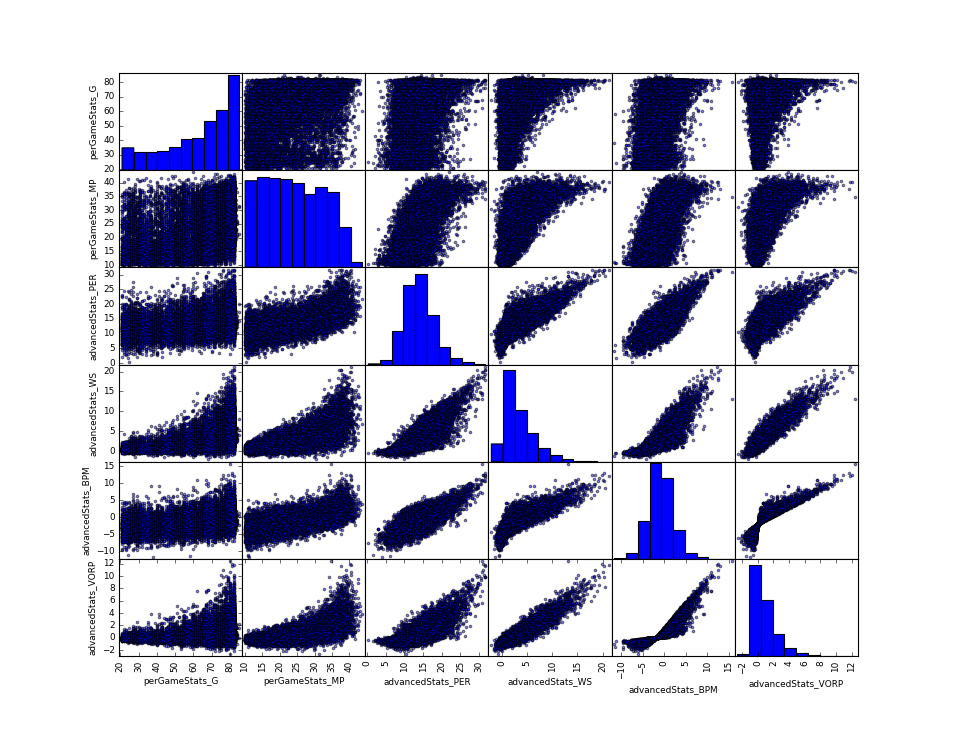

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

In [27]:
from pandas.tools.plotting import scatter_matrix

# Build scatterplot matrix
ax = scatter_matrix(playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_G',
    'perGameStats_MP',
    'advancedStats_PER',
    'advancedStats_WS',
    'advancedStats_BPM',
    'advancedStats_VORP'
]])

# We have to set axis labels manaully with Pandas' scatter_matrix function. Maybe there's a better function out there for
#   scatterplot matrices, but for now, this is fairly simple.
[plt.setp(item.xaxis.get_label(), 'size', 8) for item in ax.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', 8) for item in ax.ravel()]

Okay, let's start with the histograms. Remember that the data here is for those who played more than 10 minutes per games and 20 games per season. All histograms are stable which is great. Nothing that looks too insane in terms of outliers on both the histograms and the scatterplots.

Some basic stats:
- PER - Median about 14, normal distribution
- BPM - Median about -1, normal distribution
- VORP - Median about 0.3, right skewed distribution
- WS - Median about 2.5, right skewed distribution

VORP and WS are right skewed which make sense because less and less players play heavy minutes and lots of games. Both a commentary on how good players are and also how healthy one can stay / lucky or fortunate one can be to avoid injuries.

BPM and PER track more or less linearly with one another, and this makes sense on the surface because they are both pure box score stats not adjusting for total minutes or games played. You would expect someone with a high PER to have a ton of box score stats and, because BPM is regressed on box score stats, hopefully a high BPM as well (leaving out the intricacies of which box score stats are more significant in the model etc etc).

If we look at VORP and WS as they trend with minutes and games played, we also see that there seems to be a cap of what kind of VORP and WS you can get by having played whatever amount of minutes. However, it's' also easy to see that just because you played a certain amount of minutes, you're obviously not guaranteed any minimum of VORP / WS. There are guys that play 70-80 games and still have poor VORP / WS.

### BPM & VORP

The BPM & VORP correlation is pretty interesting. Remember that 

$$VORP=(BPM-(2.0))\times (\%\ of\ Minutes\ Played)\times (\%\ of\ Games\ Played)$$

Let's say a guy plays 82 games. We rarely see anyone average 48 minutes a game, and looking back at our summary stats of this dataframe, mean is around 24 and max is around 44. The 75th percentile of plays 31 minutes - about 2/3 of the minutes available for a player, and that's getting to pretty high calibre players.

If you play 2/3 of your minutes, and play all 82 games, your multiplier becomes 0.667. If you're sitting at around 6 BPM, you would be 8 BPM above a replacement player, and your multiplier would bring you down to 5.3.

If you're sitting at around 4 BPM, you would be 6 BPM above a replacement player, and your multiplier would bring you down to 4.

Ah, maybe I should just graph this...

<IPython.core.display.Javascript object>


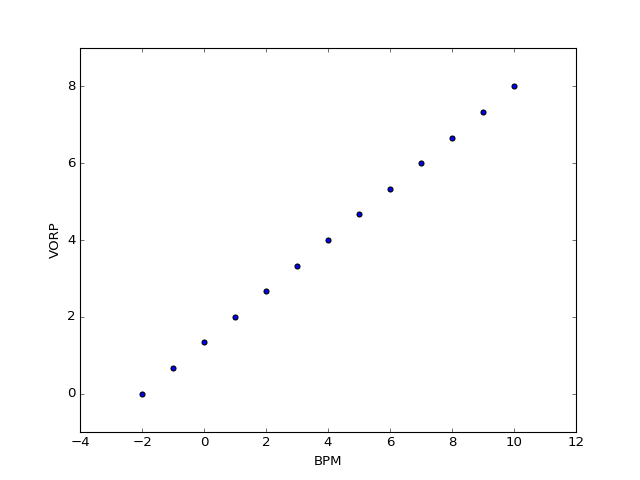

In [48]:
# Define constants in VORP equation
percGamesPlayed = 1
percMinutesPlayed = 0.6667

# Define BPM, which consists of -2, -1, 0,..., 9, 10, 11
BPM = range(-2, 11)

# Calculate VORP for each BPM
VORP = [((i+2)*percMinutesPlayed*percGamesPlayed) for i in BPM]

# Plot
pd.DataFrame({
    'BPM': BPM,
    'VORP': VORP
}).plot(
    kind = 'scatter',
    x = 'BPM',
    y = 'VORP'
)

It looks like BPM = VORP = 4 is somewhat of a break even point. Any lower BPM and your VORP goes higher (playing 2 / 3 of your minutes, that is), and any higher your VORP decreases. I'm not even sure if this is useful but I just wanted to get the relationship of BPM and VORP to keep in the back of my head. If you played less minutes from here on out, the break even point will move higher (your BPM would have to be higher to maintain the same value of VORP). Vice versa.

The BPM to VORP graph still has some explaining to do though... what the hell is actually happening there?

<IPython.core.display.Javascript object>


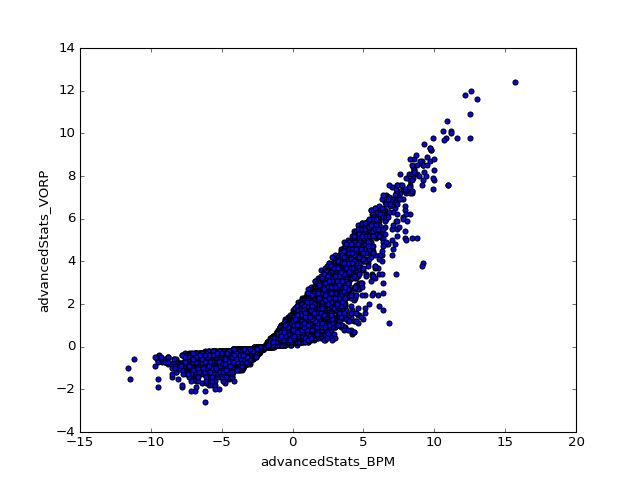

In [51]:
# Larger plot of BPM vs VORP
playerAggDfToAnalyzeMin10Min20Games.plot(
    kind = 'scatter',
    x = 'advancedStats_BPM',
    y = 'advancedStats_VORP'
)

<IPython.core.display.Javascript object>


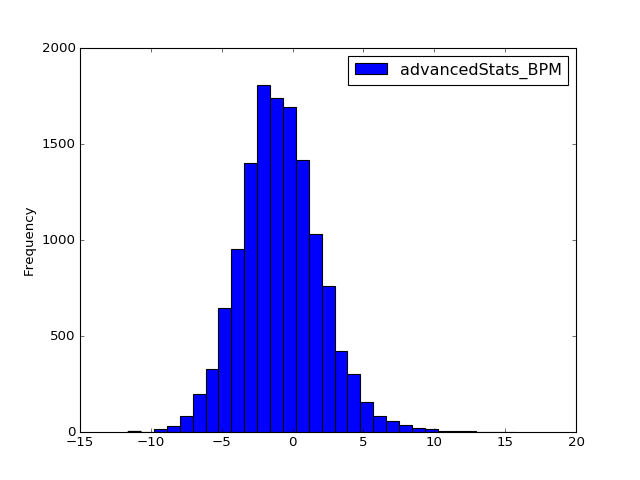

In [60]:
# BPM histogram
playerAggDfToAnalyzeMin10Min20Games[['advancedStats_BPM']].plot(
    kind = 'hist',
    bins = 30
)

So there's a bottleneck at -2, an dthis is basically because -2+2=0 and there's nothing the amount of minutes or games played that you can accumulate that will even break math. I guess that explains a part of the bowtie. Let's break this up into a few parts

_**BPM < -5**_

So we know from the basketball-reference that VORP was designed with values in mind already. -2 is a replacement player, we know that. It was also designed such that -5 was a really bad player and 5 started to yield good players. The mean on BPM again is basically -1 and the standard deviation is around 3. BPM distribution looks relatively normal, so 66% of the data should be contained within -4 and 2. 95% of the data is contained within -7 and 5.

In this region, then, we have ~5% of the players. ~5% of the worst players in the league in terms as far as BPM is concerned. It can maybe be deduced that these players aren't getting much playing time at all, and are likely not playing many games either. We see BPMs all the way down to -10, however their VORP oly hovers at -2. I think the multipliers are coming into effect here, and in fact, the multiplier are basically _**helping**_ their VORP! This makes me think that VORP probably wasn't actually intended on using it against players with the worst players in the league attributing the following qualities:
- Extremely low BPM
- Extremely low minutes
- Extremely low games played

_**-5 < BPM < -2**_

In this region, players seem to be getting decent playing minutes and games, but we anticipate the same problem... not playing much actually _**helps**_ a player's VORP if they have < -2 BPM. There are still a decent amount of players in this range though, so are we just supposed to ingore them? I'll have to do more reading here.

_**-2 < BPM < 5**_

Most players lie in this range, and we can see the variety of values VORP takes on with BPM. From the -2 BPM point, it almost funnels out to the right and some players have close to 0 VORP, while others reach 6. This will just have to be a function of how many minutes and games guys play, and those near the top of the funnel are high performing players who put in solid minutes every game.

_**BPM > 5**_

There's another clear "break" here, if you will as we now enter into the elite 5% of the league. These players have great production for as long as they are on the floor, with at least 7 BPM higher than a replacement player (5 + 2). I guess if your player is producing this much, they're probably pretty good and you're gonna play them for pretty high minutes.

I think the biggest reason why this break is here is that it is _**HARD**_ to reach this level of elite. There are only few players who do it, and with every one of these players likely getting heavy minutes and games, they ride the top border of that funnel.

---

Okay, this makes a bit more sense now!

## VORP & WS
High VORP implies high BPM and high minutes / games played. If you're that productive and playing that much, you'd better be contributing to points. The VORP & WS plot implies that they are, in fact, closely tied. This begs the question if both really need to be considered, or rather, what are the pros and cons of each? These are by far the two most all-encompassing metrics, so how they they compare and contrast with each other?

<IPython.core.display.Javascript object>


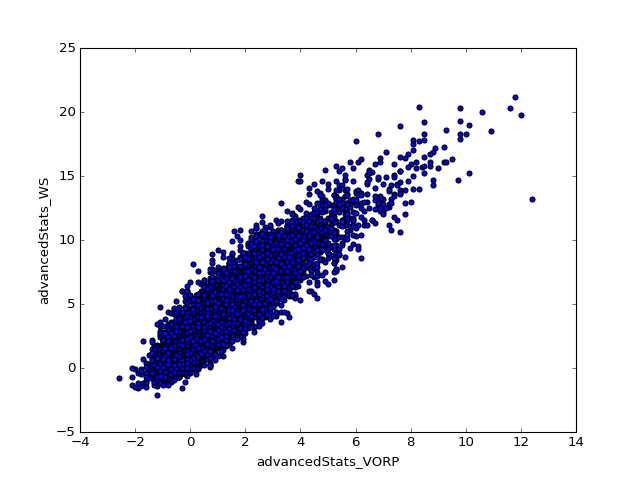

In [61]:
# Larger plot of BPM vs VORP
playerAggDfToAnalyzeMin10Min20Games.plot(
    kind = 'scatter',
    x = 'advancedStats_VORP',
    y = 'advancedStats_WS'
)

This essentially implies that there exists a factor in which you multiply VORP and you'll get WS. This would be the slope of the line, let's figure out what that is.

In [ ]:
%%R -i playerAggDfToAnalyzeMin10Min20Games

# Run linear regression model on WS as a function of VORP
vorpWsLinReg = lm(advancedStats_WS ~ advancedStats_VORP, data = playerAggDfToAnalyzeMin10Min20Games)
summary(vorpWsLinReg)

### TECHNOLOGY SIDENOTE...
Okay, so it seems that technology has failed me once again. For some reason, the %R magic only outputs the command output to the notebook if I use the %R magic operator. If I use the %%R magic operator, it outputs to the command prompt where I started Jupyter notebook... Googling a bit has yielded no result unfortunately. I'll try to stick with the %R where I can

In [67]:
# Print linaer regression coefficients, where the first argument is B0, and the second argument in B1 (coefficient of VORP)
%R print(vorpWsLinReg$coefficients)

array([ 1.82420618,  1.85629232])

So, I guess

$$WS=VORP\times 1.86$$

?? Don't quote me on this, but that _**seems**_ to be the case through historical data.

Good to know, whatever that means. Let's try to figure out why VORP would differentiate from WS.

The first thing I wanted to check out was where VORP < 0. This was the case where BPM < -2. Doesn't really matter in this plot because everyone sucks so much that they're all basically useless (0 or negative WS).

The second is where VORP is greater than WS. Well the answer really lies in something that I don't quite know, I suppose.
- #1 - I literally didn't take the time to look at player ORtg (points produced) and DRtg definitions, which is the lifeblood of the WS calculation... so in essence I have no idea how WS is calculated right now
- #2 - I never really studied the ridge regressed model to look at which features were significant in the VORP calculation, so I basically also have no idea how VORP is calculated right now

I'm not _**quite**_ in the mood to look at all these numbers right now, and I feel like I won't be able to avoid it in the future, but I'm going to skip this question for now and just take a look at how these metrics correlate to subjectively deemed great players. For this, I'm going to take a look at all-NBA and all-star teams.

Actually... you know what... this post is long enough. Let's save it for the next one haha.